In [1]:
import A_GIS
import numpy
import ast

In [2]:
image = A_GIS.Image.open(path='/Users/ww5/Downloads/download.png')
cs=A_GIS.Image.get_character_scale(image=image)
w, h = image.size
max_w=w/cs.wh_scale[0]
print('max_w:',max_w)
max_h=h/cs.wh_scale[1]
print('max_h:',max_h)

max_w: 112.85714285714286
max_h: 61.7


In [3]:
# These are part of image_iter so don't move them.
box_tries=[]
images=[]
def image_iter(ul,wh):
    lr=(ul[0]+wh[0],ul[1]+wh[1])
    #reduce the alpha for all existing boxes.
    for box_try in box_tries:
        r,g,b,a = box_try[2]
        box_try[2] = (0.0,0.0,1.0,0.5*a) #switch to blue
    # add the new box
    box_tries.append([ul,lr,(1.0,0.0,0.0,1.0)])
    gridded = A_GIS.Image.show(
        image=image,
        wh_scale=cs.wh_scale,
        grid=True,
        nticks=1,
        nlabels=10,
        show=True,
        close=True,
        dpi=10,
        boxes=box_tries
    )
    images.append( gridded.image )
def convert_to_bytes(image):
    """
    Converts a PIL Image to bytes.

    Args:
        image (PIL.Image.Image): The PIL Image to be converted.

    Returns:
        bytes: The image data in bytes.
    """
    from io import BytesIO
    buffer = BytesIO()
    image.save(buffer, format=image.format if image.format else "PNG")
    return buffer.getvalue()

def make_message0(box_tries,thing='email address'):
    import textwrap
    ul=box_tries[-1][0]
    lr=box_tries[-1][1]
    wh=(lr[0]-ul[0],lr[1]-ul[1])
    message= f'''You are to draw a bounding box to isolate the {thing} in 
terms of the (w,h) coordinate of the uppler left corner and the total 
width,height of the box. Use the coordinate system and axes provided in the image.
Note that the x-axis is the width w-axis and is a typical left to right axis.
However the y-axis is the height h-axis and starts at zero at the upper left corner
of the image.

Your last attempt to draw a bounding box around the {thing} is shown in red with 
a dot at the upper left coordinate (w,h)={ul} and 
the total size (width,height)={wh}.
First say where the box should move: left, right, up, or down to better isolate the {thing}.
For example, 

  The current box should move left and down to isolate the {thing}.

Next, give how much the box should move. Use the axes for scale. 
For example,

  The current box should move left 20 units and down 10 units.

Next, give the new coodinates of the top left corner of the bounding box.
If the box would move to the left, its w-coordinate will decrease. 
If it should move up, its h-coordinate will decrease.
For example,
  Because the box should move left 20 units and the current w-coordinate of
  the upper left corner is 25, the new upper left w-coordinate is 25-20=5.
  
  Because the box should move down 10 units and the current h-coordinate of
  the upper left corner is 20, the new upper left h-coordinate is 20+10=30.
  
  This gives a final (w,h)=(5,30) for the bounding box upper left coordinate.
  
Finally, give the new size of the box in terms of width and height. These values
will always be positive. A height of 2 or 3 is typical for isolating text. The
width depends on the length of the text to isolate.
Use your own judgement and keep moving the box around until you have a nice
tight fit.'''
    return message

def system_message(thing='email address'):
    return f'''
You are to draw a red point on the {thing} in the image. To draw the point,
give the (w,h) coordinate. We are using typical image coordinates where the horizontal
axis, the width axis or w-axis is the same as a typical x-axis. However, the 
height axis or h-axis is the reverse of a typical y-axis and starts at zero
in the upper left corner of the image. (w,h) coordinates are always positive.
(0,0) is the upper left of the image.

Note that the coordinates are NOT pixels. 

First note if the red point is far or close to the {thing}.

Then note the directions the point should move to be closer to the {thing}: up, down, left, and/or right.

Then use the axes and grid lines on the image to determine an approximate (w,h) coordinate
for the current location of the red dot. This shows you understand the axis system.

Finally, make a new estimate for the (w,h) coordinate of the {thing}.

Note that your last estimate is shown as a red dot and any previous
estimates are shown in progressively lighter shades of blue.

DO NOT JUST GUESS AT THE LOCATION. BE METHODICAL. USE THE AXES AND 
THESE GUIDELINES.
    '''
    
def make_message(box_tries,thing='email address'):
    import textwrap
    ul=box_tries[-1][0]
    lr=box_tries[-1][1]
    wh=(lr[0]-ul[0],lr[1]-ul[1])
    message = system_message(thing)
    message+= f'''

Guidelines:

If the point should move left, the w-coordinate should decrease to be between 0 and {ul[0]:.1f}.
If the point should move right, the w-coordinate should increase to be between {ul[0]:.1f} and {max_w:.1f}.

If the point should move up, the h-coordinate should decrease to be between 0 and {ul[1]:.1f}.
If the point should move down, the h-coordinate should increase to be between {ul[1]:.1f} and {max_h:.1f}.

Your reply should be succinct with these lines.

1. The red point is ... away from the {thing}.
2. The red point should move ... to be closer to the {thing}.
3. The red point is currently located at (w,h) = ...
4. The red point should move to the coordinate (w,h)= ...
    '''
    return message


In [4]:
messages=[]
fulls=[]
contents=[]

In [5]:
chatbot=A_GIS.Ai.Chatbot.init(model='llama3.2-vision:90b',num_ctx=50000,num_predict=5000)
processor = A_GIS.Ai.Chatbot.init(model='qwen2.5:latest')

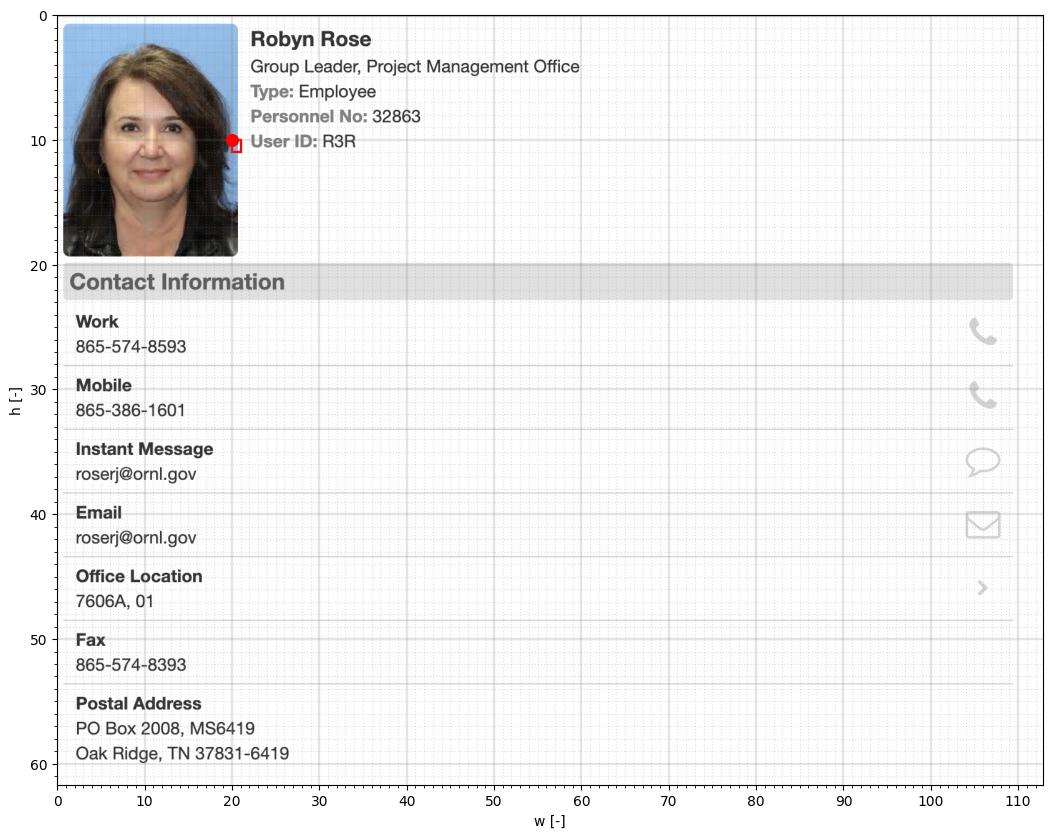


You are to draw a red point on the email address in the image. To draw the point,
give the (w,h) coordinate. We are using typical image coordinates where the horizontal
axis, the width axis or w-axis is the same as a typical x-axis. However, the 
height axis or h-axis is the reverse of a typical y-axis and starts at zero
in the upper left corner of the image. (w,h) coordinates are always positive.
(0,0) is the upper left of the image.

Note that the coordinates are NOT pixels. 

First note if the red point is far or close to the email address.

Then note the directions the point should move to be closer to the email address: up, down, left, and/or right.

Then use the axes and grid lines on the image to determine an approximate (w,h) coordinate
for the current location of the red dot. This shows you understand the axis system.

Finally, make a new estimate for the (w,h) coordinate of the email address.

Note that your last estimate is shown as a red dot and any previous
estimates are 

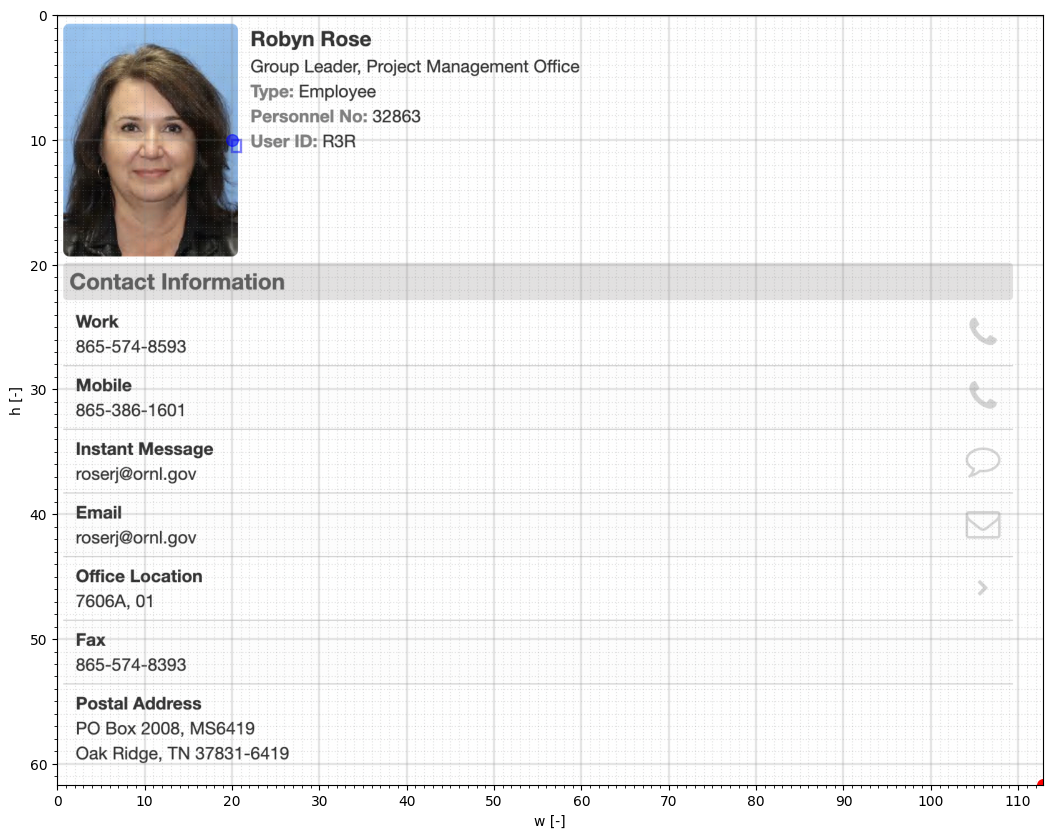


You are to draw a red point on the email address in the image. To draw the point,
give the (w,h) coordinate. We are using typical image coordinates where the horizontal
axis, the width axis or w-axis is the same as a typical x-axis. However, the 
height axis or h-axis is the reverse of a typical y-axis and starts at zero
in the upper left corner of the image. (w,h) coordinates are always positive.
(0,0) is the upper left of the image.

Note that the coordinates are NOT pixels. 

First note if the red point is far or close to the email address.

Then note the directions the point should move to be closer to the email address: up, down, left, and/or right.

Then use the axes and grid lines on the image to determine an approximate (w,h) coordinate
for the current location of the red dot. This shows you understand the axis system.

Finally, make a new estimate for the (w,h) coordinate of the email address.

Note that your last estimate is shown as a red dot and any previous
estimates are 

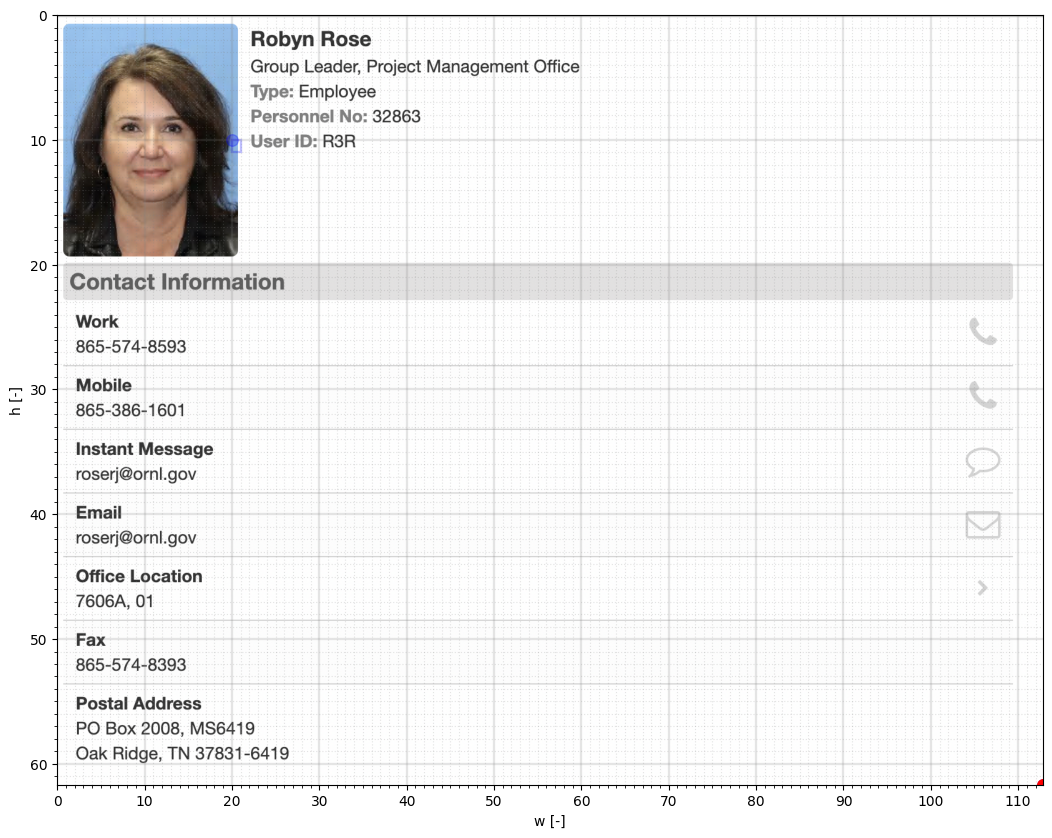


You are to draw a red point on the email address in the image. To draw the point,
give the (w,h) coordinate. We are using typical image coordinates where the horizontal
axis, the width axis or w-axis is the same as a typical x-axis. However, the 
height axis or h-axis is the reverse of a typical y-axis and starts at zero
in the upper left corner of the image. (w,h) coordinates are always positive.
(0,0) is the upper left of the image.

Note that the coordinates are NOT pixels. 

First note if the red point is far or close to the email address.

Then note the directions the point should move to be closer to the email address: up, down, left, and/or right.

Then use the axes and grid lines on the image to determine an approximate (w,h) coordinate
for the current location of the red dot. This shows you understand the axis system.

Finally, make a new estimate for the (w,h) coordinate of the email address.

Note that your last estimate is shown as a red dot and any previous
estimates are 

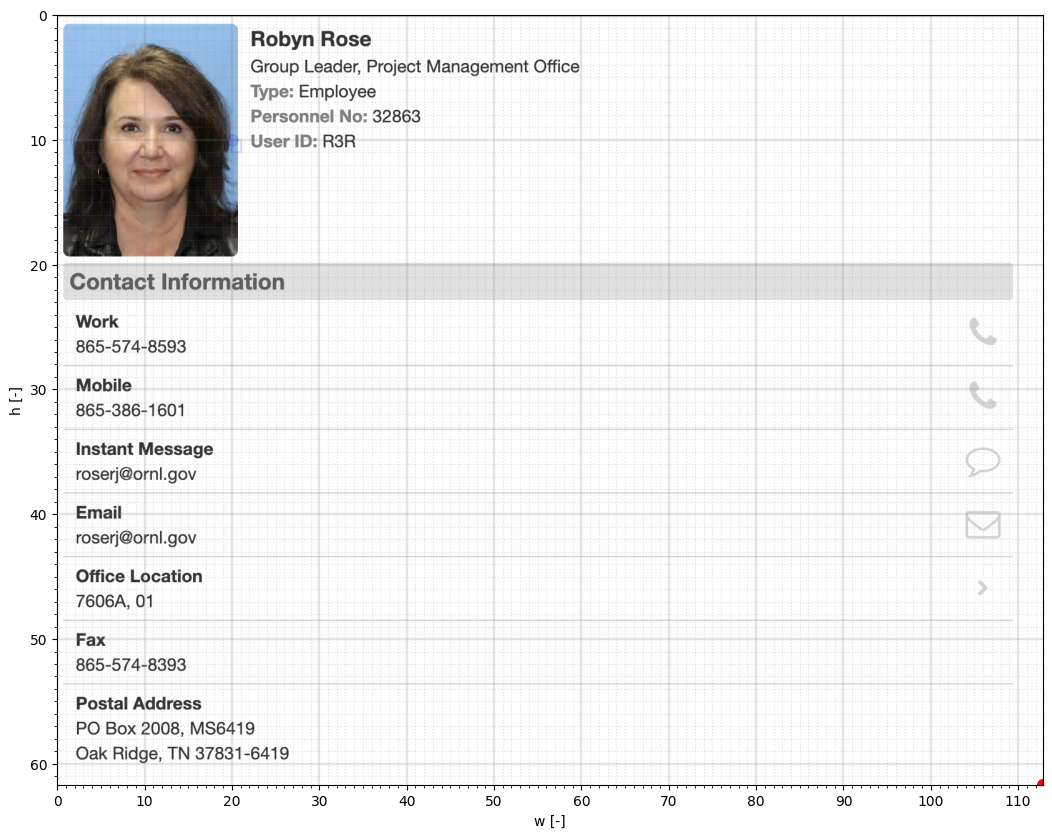


You are to draw a red point on the email address in the image. To draw the point,
give the (w,h) coordinate. We are using typical image coordinates where the horizontal
axis, the width axis or w-axis is the same as a typical x-axis. However, the 
height axis or h-axis is the reverse of a typical y-axis and starts at zero
in the upper left corner of the image. (w,h) coordinates are always positive.
(0,0) is the upper left of the image.

Note that the coordinates are NOT pixels. 

First note if the red point is far or close to the email address.

Then note the directions the point should move to be closer to the email address: up, down, left, and/or right.

Then use the axes and grid lines on the image to determine an approximate (w,h) coordinate
for the current location of the red dot. This shows you understand the axis system.

Finally, make a new estimate for the (w,h) coordinate of the email address.

Note that your last estimate is shown as a red dot and any previous
estimates are 

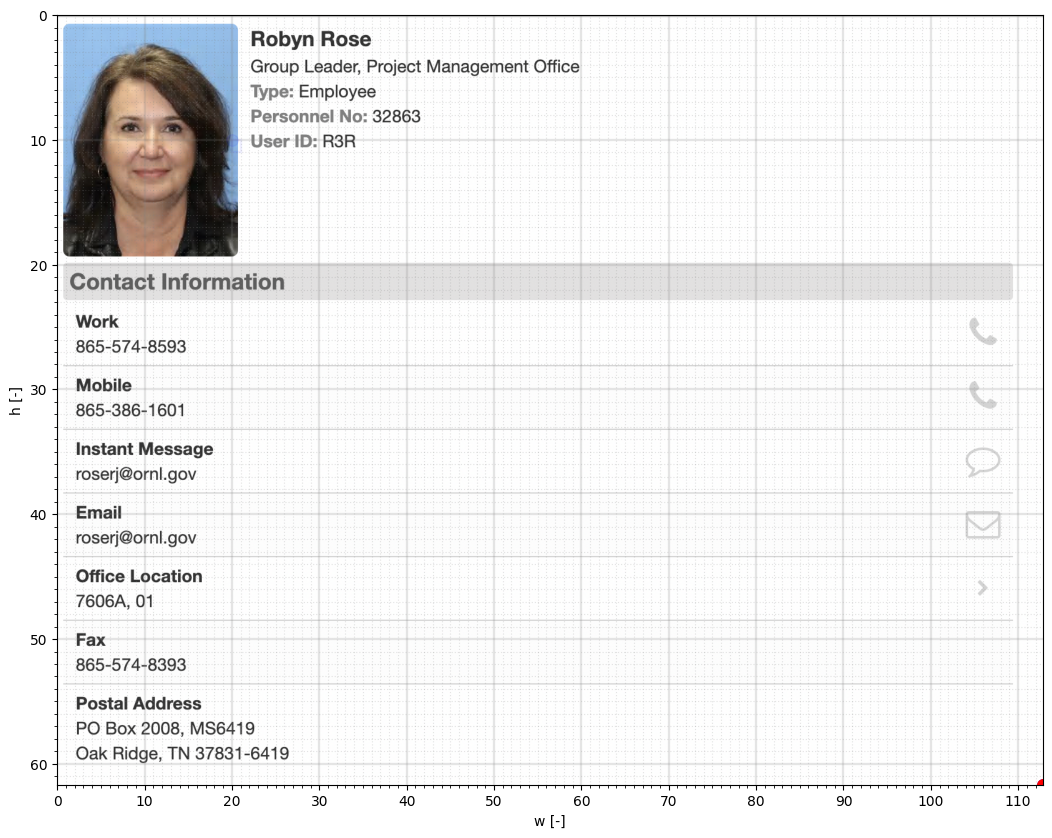


You are to draw a red point on the email address in the image. To draw the point,
give the (w,h) coordinate. We are using typical image coordinates where the horizontal
axis, the width axis or w-axis is the same as a typical x-axis. However, the 
height axis or h-axis is the reverse of a typical y-axis and starts at zero
in the upper left corner of the image. (w,h) coordinates are always positive.
(0,0) is the upper left of the image.

Note that the coordinates are NOT pixels. 

First note if the red point is far or close to the email address.

Then note the directions the point should move to be closer to the email address: up, down, left, and/or right.

Then use the axes and grid lines on the image to determine an approximate (w,h) coordinate
for the current location of the red dot. This shows you understand the axis system.

Finally, make a new estimate for the (w,h) coordinate of the email address.

Note that your last estimate is shown as a red dot and any previous
estimates are 

In [6]:
ul=(20,10)
for s in range(5):
    image_iter(ul,(1,1))
    messages.append(make_message(box_tries))
    print(messages[-1])
    fulls.append( chatbot.chat(message=messages[-1],images=[convert_to_bytes(images[-1])]) )
    contents.append( fulls[-1].response['message']['content'] )
    print(contents[-1])
    result = processor.chat(message=contents[-1]+'\nWhat was the final coordinate given. Only output that (w,h)!')
    tuple_string = result.response['message']['content']
    ul = ast.literal_eval(tuple_string)
    print(tuple_string,ul)